# Model Building

This notebook trains and examins different ML classifiers on training data dataset. 

* K Nearest neighbours
* SVM
* Random forest
* Logistic regression
* Decision Tree
* ADABoost
* ANN

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import pickle

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df_tr = pd.read_csv('./data/train_features_processed.csv')
y_tr = pd.read_csv('./data/train_labels_processed.csv')
y_tr = y_tr.squeeze()

In [3]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      891 non-null    float64
 1   SibSp    891 non-null    float64
 2   Parch    891 non-null    float64
 3   Fare     891 non-null    float64
 4   female   891 non-null    float64
 5   C        891 non-null    float64
 6   Q        891 non-null    float64
 7   Class_2  891 non-null    float64
 8   Class_3  891 non-null    float64
dtypes: float64(9)
memory usage: 62.8 KB


## 1. Splitting training data
 Split training dataset into training dataset, cross validation dataset and test dataset - 55%,25% and 20% resp. 

In [4]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(df_tr,
                                                              y_tr,
                                                              test_size=0.2,
                                                              random_state=42)

In [5]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train_temp,
                                                y_train_temp,
                                                test_size=0.25)

In [6]:
type(y_train)

pandas.core.series.Series

## 2. Model development

In [7]:
def bestModel(model, X_train, X_cv, y_train, y_cv, grid):
    model_cv = GridSearchCV(model, grid, cv=4)
    model_cv.fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", model_cv.best_params_)
    print("accuracy :", model_cv.best_score_)
    mod_best= model_cv.best_estimator_
    return mod_best


def testModel(model, X_train, X_cv, y_train, y_cv):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred_cv = model.predict(X_cv)
    precision_tr, recall_tr, fscore_tr, support_tr = precision_recall_fscore_support(
        y_train, y_pred_tr, average='macro')
    precision_cv, recall_cv, fscore_cv, support_cv = precision_recall_fscore_support(
        y_cv, y_pred_cv, average='macro')
    report= np.array([precision_tr, recall_tr, fscore_tr, precision_cv, recall_cv, fscore_cv])
    return report

### 1. Logistic Regression

In [8]:
logReg = LogisticRegression(class_weight='auto', max_iter=200)
grid = {
    'C': np.logspace(-5, 0, 40),
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}
logReg_best=bestModel(logReg, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'C': 0.17012542798525856, 'solver': 'newton-cg'}
accuracy : 0.8016215912916619


### 2. K-Nearest neighbours

In [9]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': np.int0(np.linspace(3, 22, 20)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_best=bestModel(knn, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'}
accuracy : 0.8034171249018068


### 3. Decision tree

In [10]:
decTree = DecisionTreeClassifier()
grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}
decTree_best=bestModel(decTree, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'splitter': 'best'}
accuracy : 0.7602822354393447


### 4. Random forest

In [11]:
rnFr = RandomForestClassifier()
grid = {
    'n_estimators': np.array([10,20,30]),
    'criterion': ['gini', 'entropy']
}
rnFr_best=bestModel(rnFr, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'n_estimators': 10}
accuracy : 0.807106385366401


### 5. SVM

In [12]:
svm = SVC()
grid = {
    'C': np.logspace(-5, 2, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
svm_best=bestModel(svm, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'C': 0.0774263682681127, 'kernel': 'poly'}
accuracy : 0.8090421950398383


### 6. ADABoost

In [13]:
adab = AdaBoostClassifier()
grid = {'algorithm': ['SAMME', 'SAMME.R']}
adab_best=bestModel(adab, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'algorithm': 'SAMME'}
accuracy : 0.7940747390865223


### 7. XGBoost

In [14]:
xgbst = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic')
grid = {'n_estimators': np.array([50, 70, 100])}
xgbst_best=bestModel(xgbst, X_train, X_cv, y_train, y_cv, grid)

[07:22:22] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:22:22] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:22:22] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:22:22] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

### 8. Neural Network

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [16]:
ann_mod=Sequential()
ann_mod.add(Dense(units=9,activation='relu'))
ann_mod.add(Dropout(0.5))
ann_mod.add(Dense(units=18,activation='relu'))
ann_mod.add(Dropout(0.5))
ann_mod.add(Dense(units=1,activation='sigmoid'))
ann_mod.compile(optimizer='adam',loss='binary_crossentropy')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [18]:
ann_mod.fit(x=X_train.values, 
          y=y_train.values, 
          epochs=600,
          validation_data=(X_cv.values, y_cv.values), verbose=1,
          callbacks=[early_stop])

Epoch 1/600
17/17 [==============================] - 1s 39ms/step - loss: 0.7100 - val_loss: 0.6929
Epoch 2/600
17/17 [==============================] - 0s 11ms/step - loss: 0.6946 - val_loss: 0.6742
Epoch 3/600
17/17 [==============================] - 0s 10ms/step - loss: 0.6620 - val_loss: 0.6591
Epoch 4/600
17/17 [==============================] - 0s 13ms/step - loss: 0.6664 - val_loss: 0.6453
Epoch 5/600
17/17 [==============================] - 0s 7ms/step - loss: 0.6589 - val_loss: 0.6314
Epoch 6/600
17/17 [==============================] - 0s 11ms/step - loss: 0.6538 - val_loss: 0.6177
Epoch 7/600
17/17 [==============================] - 0s 13ms/step - loss: 0.6300 - val_loss: 0.6045
Epoch 8/600
17/17 [==============================] - 0s 16ms/step - loss: 0.6203 - val_loss: 0.5901
Epoch 9/600
17/17 [==============================] - 0s 13ms/step - loss: 0.6215 - val_loss: 0.5781
Epoch 10/600
17/17 [==============================] - 0s 14ms/step - loss: 0.6258 - val_loss: 0.5677


17/17 [==============================] - 0s 12ms/step - loss: 0.4829 - val_loss: 0.4433
Epoch 83/600
17/17 [==============================] - 0s 11ms/step - loss: 0.5075 - val_loss: 0.4431
Epoch 84/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4901 - val_loss: 0.4429
Epoch 85/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4822 - val_loss: 0.4426
Epoch 86/600
17/17 [==============================] - 0s 15ms/step - loss: 0.4268 - val_loss: 0.4405
Epoch 87/600
17/17 [==============================] - 0s 12ms/step - loss: 0.5035 - val_loss: 0.4410
Epoch 88/600
17/17 [==============================] - 0s 12ms/step - loss: 0.5090 - val_loss: 0.4411
Epoch 89/600
17/17 [==============================] - 0s 11ms/step - loss: 0.5094 - val_loss: 0.4419
Epoch 90/600
17/17 [==============================] - 0s 7ms/step - loss: 0.4706 - val_loss: 0.4420
Epoch 91/600
17/17 [==============================] - 0s 11ms/step - loss: 0.5107 - val_loss: 0.4420
Epoc

Epoch 163/600
17/17 [==============================] - 0s 8ms/step - loss: 0.4767 - val_loss: 0.4320
Epoch 164/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4793 - val_loss: 0.4323
Epoch 165/600
17/17 [==============================] - 0s 11ms/step - loss: 0.4676 - val_loss: 0.4314
Epoch 166/600
17/17 [==============================] - 0s 8ms/step - loss: 0.5014 - val_loss: 0.4309
Epoch 167/600
17/17 [==============================] - 0s 12ms/step - loss: 0.4292 - val_loss: 0.4305
Epoch 168/600
17/17 [==============================] - 0s 11ms/step - loss: 0.5035 - val_loss: 0.4317
Epoch 169/600
17/17 [==============================] - 0s 6ms/step - loss: 0.4568 - val_loss: 0.4308
Epoch 170/600
17/17 [==============================] - 0s 11ms/step - loss: 0.4334 - val_loss: 0.4296
Epoch 171/600
17/17 [==============================] - 0s 11ms/step - loss: 0.5157 - val_loss: 0.4297
Epoch 172/600
17/17 [==============================] - 0s 11ms/step - loss: 0.4400 - 

17/17 [==============================] - 0s 11ms/step - loss: 0.4208 - val_loss: 0.4203
Epoch 244/600
17/17 [==============================] - 0s 7ms/step - loss: 0.4874 - val_loss: 0.4199
Epoch 245/600
17/17 [==============================] - 0s 11ms/step - loss: 0.4593 - val_loss: 0.4196
Epoch 246/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4342 - val_loss: 0.4187
Epoch 247/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4631 - val_loss: 0.4191
Epoch 248/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4310 - val_loss: 0.4193
Epoch 249/600
17/17 [==============================] - 0s 11ms/step - loss: 0.4570 - val_loss: 0.4188
Epoch 250/600
17/17 [==============================] - 0s 11ms/step - loss: 0.4792 - val_loss: 0.4193
Epoch 251/600
17/17 [==============================] - 0s 11ms/step - loss: 0.5068 - val_loss: 0.4194
Epoch 252/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4488 - val_loss: 0.

<AxesSubplot:>

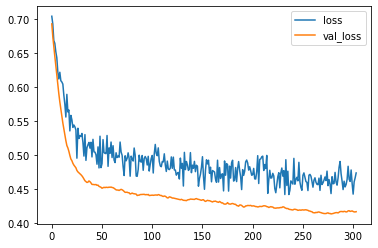

In [19]:
model_loss=pd.DataFrame(ann_mod.history.history)
model_loss.plot()

In [20]:
y_pred_tr = ann_mod.predict_classes(X_train.values)
y_pred_cv = ann_mod.predict_classes(X_cv.values)
precision_tr, recall_tr, fscore_tr, support_tr = precision_recall_fscore_support(
    y_train.values, y_pred_tr, average='macro')
precision_cv, recall_cv, fscore_cv, support_cv = precision_recall_fscore_support(
    y_cv.values, y_pred_cv, average='macro')

/home/chaitanya/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [21]:
print(precision_tr, recall_tr, fscore_tr, support_tr)
print(precision_cv, recall_cv, fscore_cv, support_cv)

0.8318387233441604 0.7777112972565705 0.7905426018740467 None
0.8557442557442557 0.7494745691467003 0.7717948717948717 None


In [24]:
ann_mod.save('ann_titanic.h5')


## 3. Model testing

In [25]:
model_list=[logReg_best,knn_best,decTree_best,rnFr_best,svm_best,adab_best,xgbst_best]

In [26]:
for model in model_list:
    print(str(model).split('(')[0])

LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
SVC
AdaBoostClassifier
XGBClassifier


In [27]:
report_d={}
for model in model_list:
    name=str(model).split('(')[0]
    filename = name + '_titanic.model'
    pickle.dump(model, open(filename, 'wb'))
    report=testModel(model, X_train, X_cv, y_train, y_cv)
    report_d[name]=report

[07:27:14] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [28]:
report_d

{'LogisticRegression': array([0.7878336 , 0.77660329, 0.78104463, 0.80071235, 0.74842371,
        0.76361222]),
 'KNeighborsClassifier': array([0.81591525, 0.78415991, 0.79375232, 0.82717391, 0.7530475 ,
        0.77192778]),
 'DecisionTreeClassifier': array([0.98552395, 0.97914728, 0.98213562, 0.7380715 , 0.73420205,
        0.73601695]),
 'RandomForestClassifier': array([0.96730129, 0.95435004, 0.96002994, 0.80071235, 0.74842371,
        0.76361222]),
 'SVC': array([0.84174549, 0.77327926, 0.78740927, 0.86624869, 0.74555135,
        0.76871853]),
 'AdaBoostClassifier': array([0.81691265, 0.79914019, 0.80570042, 0.82088555, 0.76909065,
        0.7850566 ]),
 'XGBClassifier': array([0.96505445, 0.95612286, 0.96018728, 0.81486569, 0.78905703,
        0.79904585])}